## Setting up

In [74]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

from rich import print

In [75]:
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

## Loading in and processing the data input

In [129]:
# KatimaMulilo (km)
km = (pd.read_csv('Katima_Mulilo/1291100_Q_Day.txt', skiprows=35, delimiter=';', header=1)
      .drop(columns=['hh:mm'])
      .rename(columns={"YYYY-MM-DD": "Date", " Value": "Discharge [m^3/s]"}))

In [130]:
# Adjusting the data-set to the experiment dates removing nans
km['Date'] = pd.to_datetime(km['Date'])
km['Year'] = km['Date'].dt.year
km['Day'] = km['Date'].dt.dayofyear

# Removing nans
km['Discharge [m^3/s]'] = km['Discharge [m^3/s]'].replace(-999.000, np.nan)

# Defining the data period
start_calibration = '1986-01-01'
end_calibration = '2019-12-31'

# Reducing the dataframe to the calibration period
km = km[(km['Date'] >= start_calibration) & (km['Date'] <= end_calibration)]

## Determining the start of the water-year

In [78]:
year = km['Year'].unique()

year_start = []

for i in year:
    yearly_data = km[km['Year'] == i].reset_index()
    year_start.append(yearly_data['Discharge [m^3/s]'].idxmin())

year_start = year_start[1:-1]
avg_minday = np.mean(year_start)
print(f'The average lowest point of the Zambezi discharge is the {avg_minday:.0f}th day of the year. This is precisely the last day of October, so the first day of November is the average start of the hydraulic year.')

The average lowest point of the Zambezi discharge is the 304th day of the year. This is precisely the last day of 
October, so the first day of November is the average start of the hydraulic year.

## A quick visual presentation of the flow

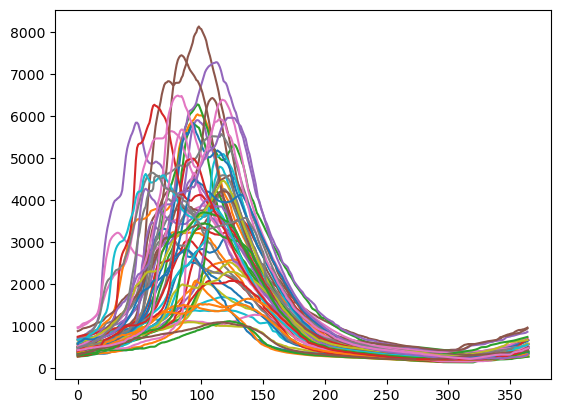

In [79]:
for j in year:
    yearly_data = km[km['Year'] == j].reset_index()
    yearly_data['Discharge [m^3/s]'].plot()

In [120]:
km['hydro_year'] = np.where(km['Day'] < 304, km['Year'], km['Year'] + 1)

## Determining critical inflow per year 

## Drought analyser

In [111]:
critical_flow = []    

def analyse_annual_deficits(data, flow_column, Q_crit, hydro_start_day, plot=False):
    deficit_years = []

    for hydro_year, group in data.groupby('hydro_year'):
        total_deficit = ((Q_crit - group[flow_column]).clip(lower=0)).sum()
        total_surplus = ((group[flow_column] - Q_crit).clip(lower=0)).sum()

        if total_deficit > total_surplus:
            if hydro_year 
            year_info = {'hydro_year': hydro_year, 'Netto [m³]': round((total_surplus - total_deficit) * 86400), 
                         'Average daily deficit [m³/s]': round((total_surplus - total_deficit) / len(group), 4)}
            deficit_years.append(year_info)

    return pd.DataFrame(deficit_years)

In [112]:
historic_droughts = analyse_annual_deficits(km, 'Discharge [m^3/s]', 1160, 304, plot=False)

In [113]:
print(historic_droughts)

hydro_year   Netto [m³]  Average daily deficit [m³/s]
0         1965  -1689971904                      -54.9434
1         1967  -2181694176                      -69.1811
2         1972  -6133553280                     -194.4937
3         1973 -14630302080                     -462.6563
4         1982 -12927603456                     -409.9316
5         1983 -13616494848                     -431.7762
6         1984 -11024011008                     -349.5691
7         1985  -8076176064                     -255.3942
8         1986  -7480622592                     -237.2090
9         1987  -4708508832                     -149.3058
10        1988  -7642778112                     -242.3509
11        1990 -16850499552                     -534.3258
12        1991  -6143326848                     -194.8036
13        1992 -19060808544                     -604.4143
14        1993  -1635418944                      -51.7171
15        1994 -12679714080                     -402.0711
16        1995 -20447984736                     -648.4013
17        1996 -23245192512                     -737.1002
18        1997 -14695708608                     -464.7246
19        2000  -7629201216                     -241.9204
20        2002  -9560227392                     -303.1528
21        2005 -15581022624                     -492.7211
22        2006  -4719832416                     -149.6649
23        2015 -13379451264                     -424.2596
24        2016   -790279200                      -25.0596
25        2017   -900821088                      -28.4868
26        2019 -20069746272                     -636.4075

In [121]:
historic_droughts['total_power_deficit [MW]'] = (- historic_droughts['Average daily deficit [m³/s]'] * 0.9 * 1000 * 9.81 * 110.5) / 10e6
historic_droughts['deficit % of power demand Zimbabwe'] = ((historic_droughts['total_power_deficit [MW]'] * 0.5) / 760) * 100
historic_droughts['deficit % of power demand Zambia'] = ((historic_droughts['total_power_deficit [MW]'] * 0.5) / 730) * 100
historic_droughts.sort_values('Average daily deficit [m³/s]', ascending=False)

,hydro_year,Netto [m³],Average daily deficit [m³/s],total_power_deficit [MW],deficit % of power demand Zimbabwe,deficit % of power demand Zambia
24,2016,-790279200,-25.0596,2.444826,0.160844,0.167454
25,2017,-900821088,-28.4868,2.779185,0.182841,0.190355
14,1993,-1635418944,-51.7171,5.045544,0.331944,0.345585
0,1965,-1689971904,-54.9434,5.360303,0.352652,0.367144
1,1967,-2181694176,-69.1811,6.749339,0.444035,0.462284
9,1987,-4708508832,-149.3058,14.566341,0.958312,0.997695
22,2006,-4719832416,-149.6649,14.601375,0.960617,1.000094
2,1972,-6133553280,-194.4937,18.974893,1.248348,1.299650
12,1991,-6143326848,-194.8036,19.005127,1.250337,1.301721
8,1986,-7480622592,-237.2090,23.142217,1.522514,1.585083
